### Import the `mdai` library

On Colab, run the block below to install the `mdai` client library into your python environment.

In [1]:
%%bash

pip install -q -U mdai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.4/282.4 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 53.8 MB/s eta 0:00:00


In [2]:
import mdai
mdai.__version__

'0.14.3'

### Create an `mdai` client

The mdai client requires an access token, which authenticates you as the user. To create a new token or select an existing token, navigate to the "Personal Access Tokens" tab on your user settings page at the specified MD.ai domain (e.g., public.md.ai).

**Important: keep your access tokens safe. Do not ever share your tokens.**

In [3]:
mdai_client = mdai.Client(domain='public.md.ai', access_token="")

Successfully authenticated to public.md.ai.


### Define project

Define a project you have access to by passing in the project id. The project id can be found in the URL in the following format: `https://public.md.ai/annotator/project/{project_id}`.

For example, `project_id` would be `XXXX` for `https://public.md.ai/annotator/project/XXXX`.

Specify optional `path` as the data directory (if left blank, will default to current working directory).

In [4]:
p = mdai_client.project('aGq4k6NW', path='./lesson2-data')

Using path './lesson2-data' for data.
Preparing annotations export for project aGq4k6NW...                                                
Preparing images export for project aGq4k6NW...                                                     


3.78MB [00:00, 176MB/s]                    


Success: annotations data for project aGq4k6NW ready.


11.4MB [00:00, 92.4MB/s]                            


Extracting archive: mdai_public_project_aGq4k6NW_images_2021-04-20-155137.zip
Success: images data for project aGq4k6NW ready.


### Set label ids

Selected label ids must be explicitly set by `Project#set_label_ids` method in order to prepare datasets.

In [5]:
p.show_label_groups()

Label Group, Id: G_Vdj4o2, Name: Default group
	Labels:
	Id: L_A8Jm3d, Name: Lung
	Id: L_dDZEvB, Name: Lung



In [6]:
# this maps label ids to class ids as a dict obj
labels_dict = {
    'L_A8Jm3d': 1, # Lung
}

print(labels_dict)
p.set_labels_dict(labels_dict)

{'L_A8Jm3d': 1}


### Create the *Training* and *Validation* datasets

In [7]:
p.show_datasets()

Datasets:
Id: D_rQLwzo, Name: Dataset



In [8]:
dataset = p.get_dataset_by_id('D_rQLwzo')
dataset.prepare()

In [9]:
image_ids = dataset.get_image_ids()
len(image_ids)

138

### Display a few images

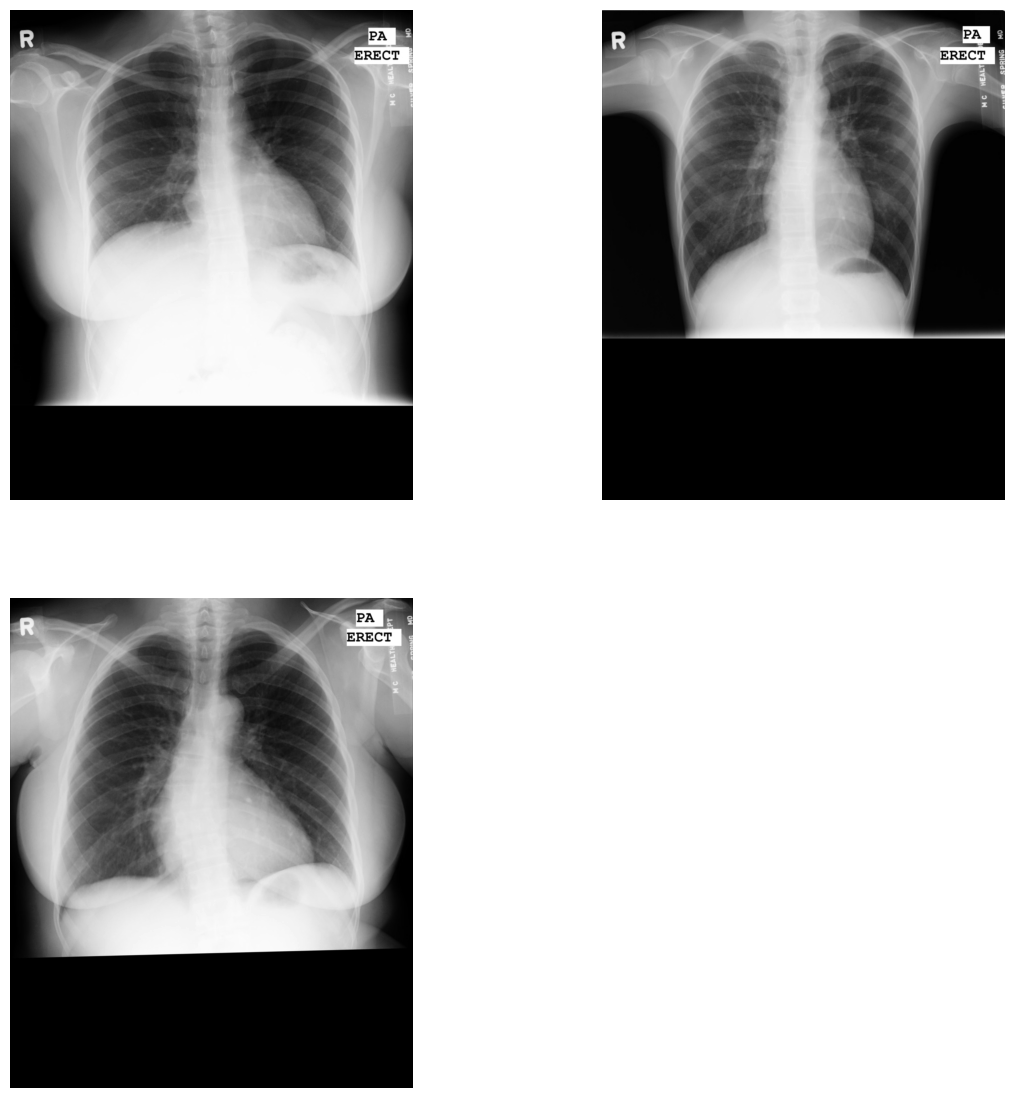

In [10]:
# visualize a few train images
mdai.visualize.display_images(image_ids[:3], cols=2)

### Prepare datasets and model

On Colab run the following %tensorflow_version line magic function to set tensorflow to v2.

In [11]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [13]:
%%bash

pip install -q keras==2.15.0
pip install -q keras-unet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.2 MB/s eta 0:00:00


In [14]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [15]:
imgs_anns_dict = dataset.imgs_anns_dict

In [16]:
def load_images(imgs_anns_dict, img_size=128):
    images = []
    masks = []

    for img_fp in imgs_anns_dict.keys():
        img = mdai.visualize.load_dicom_image(img_fp)
        ann = imgs_anns_dict[img_fp]

        img_width = img.shape[1]
        img_height = img.shape[0]

        mask = np.zeros((img_height, img_width), dtype=np.uint8)

        assert img.shape == mask.shape

        for a in ann:
            vertices = np.array(a['data']['vertices'])
            vertices = vertices.reshape((-1, 2))
            cv2.fillPoly(mask, np.int32([vertices]), (255, 255, 255))

        # resizing and padding
        if img.shape[0] == img.shape[1]:
            resized_shape = (img_size, img_size)
            offset = (0, 0)

        # height > width
        elif img.shape[0] > img.shape[1]:
            resized_shape = (img_size, round(img_size * img.shape[1] / img.shape[0]))
            offset = (0, (img_size - resized_shape[1]) // 2)

        else:
            resized_shape = (round(img_size * img.shape[0] / img.shape[1]), img_size)
            offset = ((img_size - resized_shape[0]) // 2, 0)

        resized_shape = (resized_shape[1], resized_shape[0])
        img_resized = cv2.resize(img, resized_shape).astype(np.uint8)
        mask_resized = cv2.resize(mask, resized_shape).astype(np.bool)

        resized_shape = (resized_shape[1], resized_shape[0])

        # add padding to square
        img_padded = np.zeros((img_size, img_size), dtype=np.uint8)
        img_padded[
            offset[0] : (offset[0] + resized_shape[0]), offset[1] : (offset[1] + resized_shape[1])
        ] = img_resized
        mask_padded = np.zeros((img_size, img_size), dtype=np.bool)
        mask_padded[
            offset[0] : (offset[0] + resized_shape[0]), offset[1] : (offset[1] + resized_shape[1])
        ] = mask_resized

        images.append(img_padded)
        masks.append(mask_padded)

    # add channel dim
    images = np.asarray(images)[:, :, :, None]
    masks = np.asarray(masks)[:, :, :, None]
    return images, masks

In [17]:
images, masks = load_images(imgs_anns_dict)

<ipython-input-16-8f51d4baf34c>:37: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_resized = cv2.resize(mask, resized_shape).astype(np.bool)
<ipython-input-16-8f51d4baf34c>:46: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_padded = np.zeros((img_size, img_size), dtype=np.bool)


79


(-0.5, 127.5, 127.5, -0.5)

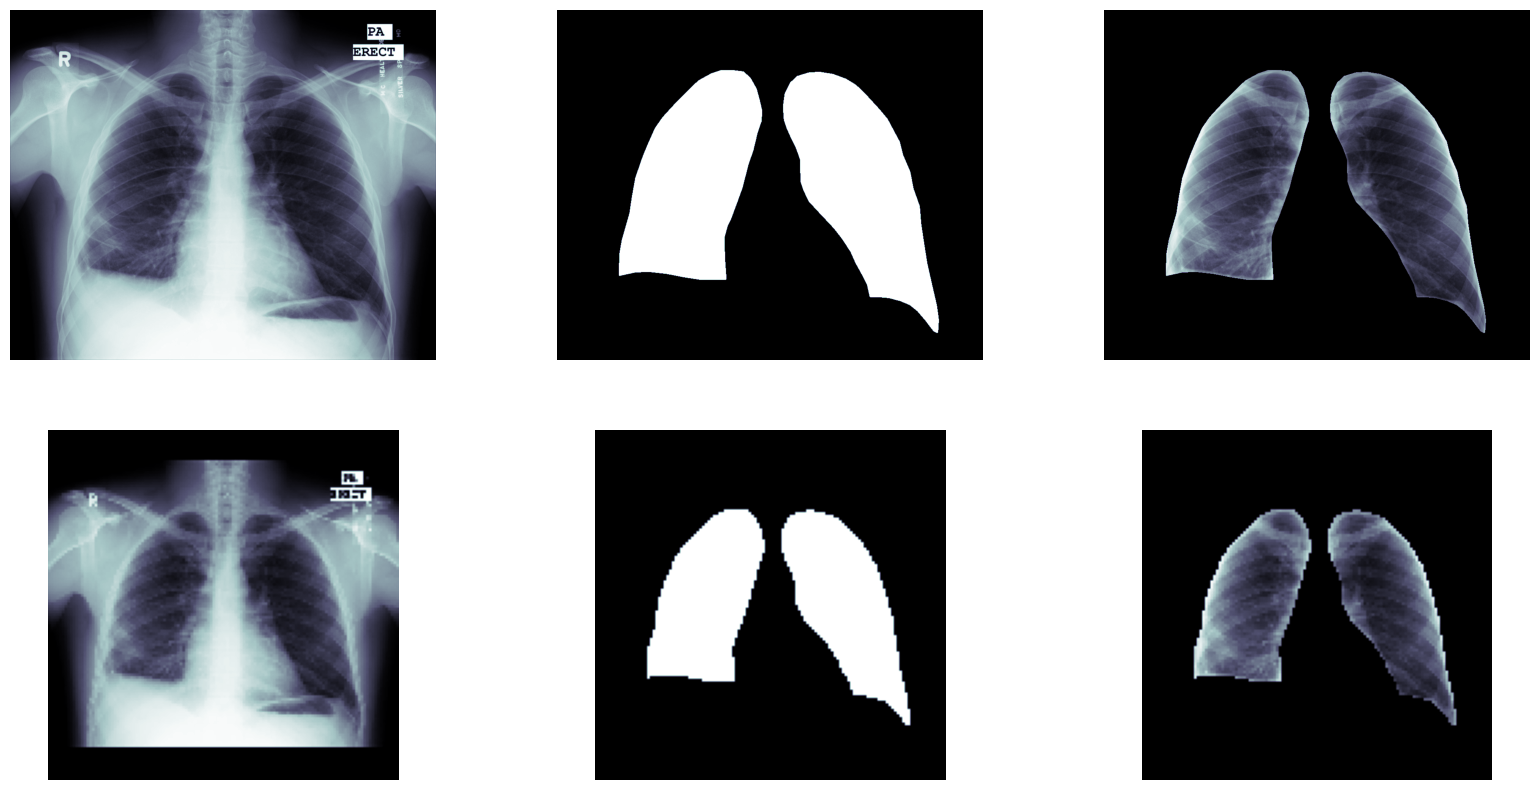

In [18]:
img_index = random.choice(range(len(imgs_anns_dict)))

print(img_index)
img_fps = list(imgs_anns_dict.keys())
img_fp = img_fps[img_index]
img = mdai.visualize.load_dicom_image(img_fp)
ann = imgs_anns_dict[img_fp]
img_width = img.shape[1]
img_height = img.shape[0]

mask = np.zeros((img_height, img_width), dtype=np.uint8)
for a in ann:
    vertices = np.array(a['data']['vertices'])
    vertices = vertices.reshape((-1,2))
    cv2.fillPoly(mask, np.int32([vertices]), (255,255,255))

plt.figure(figsize=(20, 10))
plt.subplot(2,3,1)
plt.imshow(img, cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(mask, cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(cv2.bitwise_and(img, img, mask=mask.astype(np.uint8)), cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(images[img_index,:,:,0], cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(masks[img_index,:,:,0], cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,6)
plt.imshow(cv2.bitwise_and(images[img_index,:,:,0], images[img_index,:,:,0],
                           mask=masks[img_index,:,:,0].astype(np.uint8)), cmap=plt.cm.bone)
plt.axis('off')

In [19]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=0)

In [20]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    x_train, y_train, batch_size=8,
    data_gen_args = dict(
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant',
    ))

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [21]:
from keras_unet.models import custom_unet

model = custom_unet(
    x_train[0].shape,
    use_batch_norm=True,
    num_classes=1,
    filters=64,
    dropout=0.2,
    output_activation='sigmoid',
)

### Train model

In [22]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
    ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto'),
]

In [23]:
from keras.optimizers import Adam
from keras_unet.metrics import iou

model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy', iou],
)

In [24]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=100,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
)

Epoch 1/10


<ipython-input-24-82852df1b7a1>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 [==============================] - ETA: 0s - loss: 0.1770 - accuracy: 0.9306 - iou: 0.6179
Epoch 1: val_loss improved from inf to 3.60650, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 66s 398ms/step - loss: 0.1770 - accuracy: 0.9306 - iou: 0.6179 - val_loss: 3.6065 - val_accuracy: 0.7835 - val_iou: 0.4467
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.0906 - accuracy: 0.9544 - iou: 0.7644
Epoch 2: val_loss improved from 3.60650 to 1.60796, saving model to model.h5
100/100 [==============================] - 18s 181ms/step - loss: 0.0906 - accuracy: 0.9544 - iou: 0.7644 - val_loss: 1.6080 - val_accuracy: 0.8829 - val_iou: 0.5501
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.0670 - accuracy: 0.9615 - iou: 0.8162
Epoch 3: val_loss improved from 1.60796 to 0.31266, saving model to model.h5
100/100 [==============================] - 18s 183ms/step - loss: 0.0670 - accuracy: 0.9615 - iou: 0.8162 - val_loss: 0.3127 - val_accuracy: 0.9424 - val_iou: 0.7482
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.0543 - accuracy: 0.9648 - iou: 0.8492
Epoch 4: val_loss 

dict_keys(['loss', 'accuracy', 'iou', 'val_loss', 'val_accuracy', 'val_iou'])


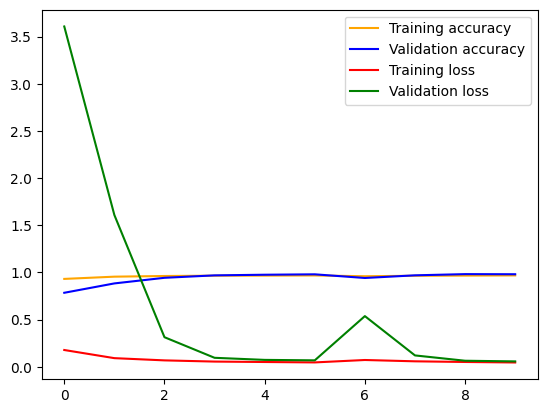

In [25]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

<ipython-input-16-8f51d4baf34c>:37: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_resized = cv2.resize(mask, resized_shape).astype(np.bool)
<ipython-input-16-8f51d4baf34c>:46: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_padded = np.zeros((img_size, img_size), dtype=np.bool)


1/1 [==============================] - 2s 2s/step


Text(0.5, 1.0, 'Predicted Lung Segmentation')

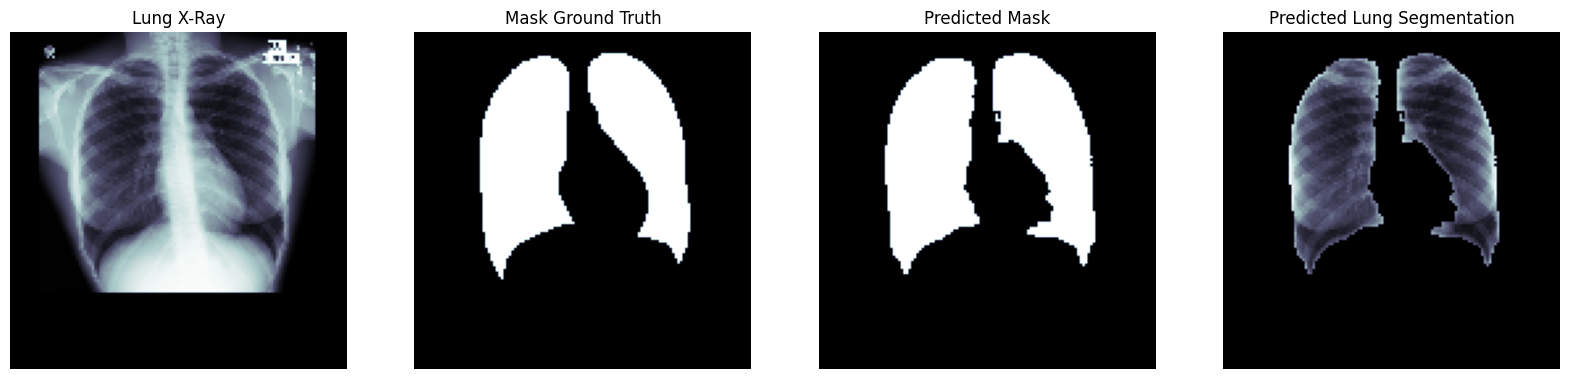

In [26]:
images, masks = load_images(imgs_anns_dict)

plt.figure(figsize=(20, 10))

img_index = random.choice(range(len(images)))

plt.subplot(1,4,1)
random_img = images[img_index,:,:,0]
plt.imshow(random_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Lung X-Ray')

plt.subplot(1,4,2)
random_mask = masks[img_index,:,:,0]
plt.imshow(random_mask, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Mask Ground Truth')

random_img_2 = np.expand_dims(np.expand_dims(random_img, axis=0), axis=3)
mask = model.predict(random_img_2)[0][:,:,0] > 0.5
plt.subplot(1,4,3)
plt.imshow(mask, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Predicted Mask')

plt.subplot(1,4,4)
plt.imshow(cv2.bitwise_and(random_img, random_img, mask=mask.astype(np.uint8)), cmap=plt.cm.bone)
plt.axis('off')
plt.title('Predicted Lung Segmentation')